# Approach 1 - using Morphological Operators

#### This approach takes advantage of the fact that the fabric is textured as "small dots" where a the defect is textured as "horizontal lines"

In [1]:
# Importing Libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

In [2]:
# display function to display zoomed image

def display_img(img):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

In [11]:
img = cv2.imread('test/img_1478.jpg', 0)    #input image

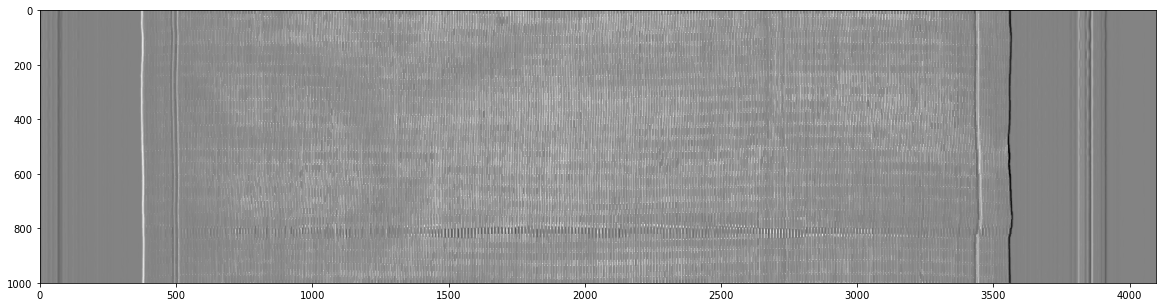

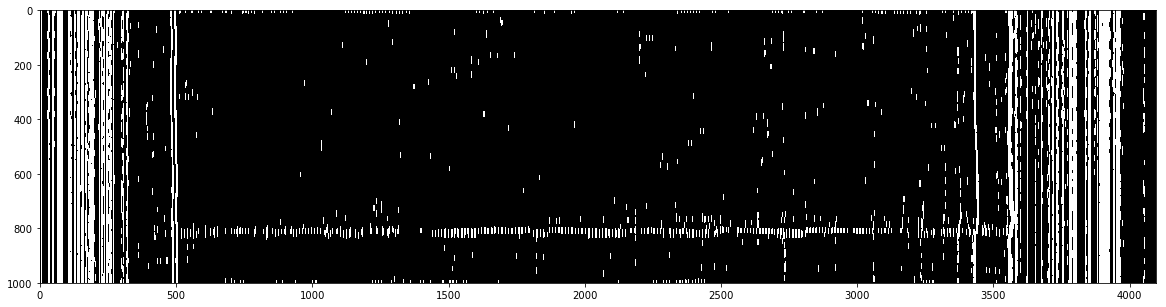

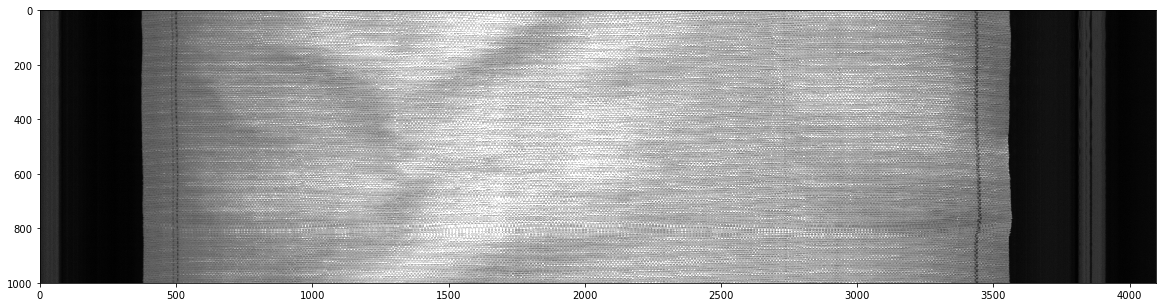

In [12]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=19)                                 # Applying sobel filter in x direction
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)                                  # Applying sobel filter in y direction
blended = cv2.addWeighted(src1=sobelx,alpha=0.25,src2=sobely,beta=0.75,gamma=0) # Merging the 2 images in 25%-75% ratio
kernel = np.ones((20,2),np.uint8)
gradient = cv2.morphologyEx(blended,cv2.MORPH_CLOSE,kernel)                     # Applying closing Morphological operation (dialation followed by erosion)
ret, thresh = cv2.threshold(gradient, 4, 255, cv2.THRESH_BINARY_INV)            # Applying binary threshold to remove noise
display_img(gradient)
display_img(thresh)
display_img(img)

#### See the "thresh" image (the middle one)  |  A Prominent white line is clearly visible  |  This white line is defect

#### Doing the same thing with different set of parameters

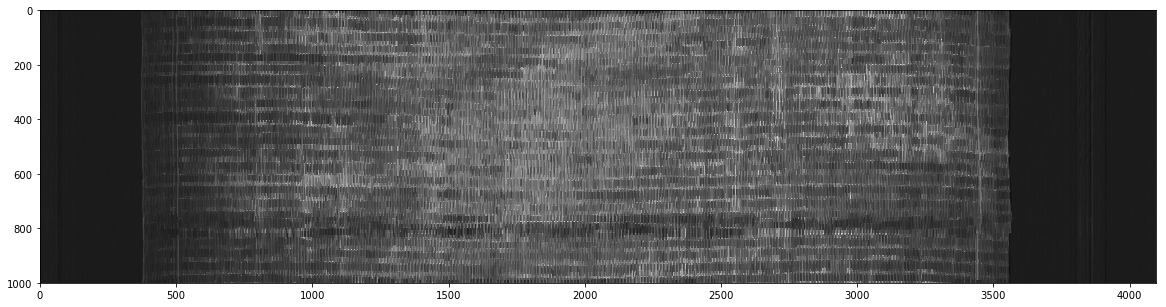

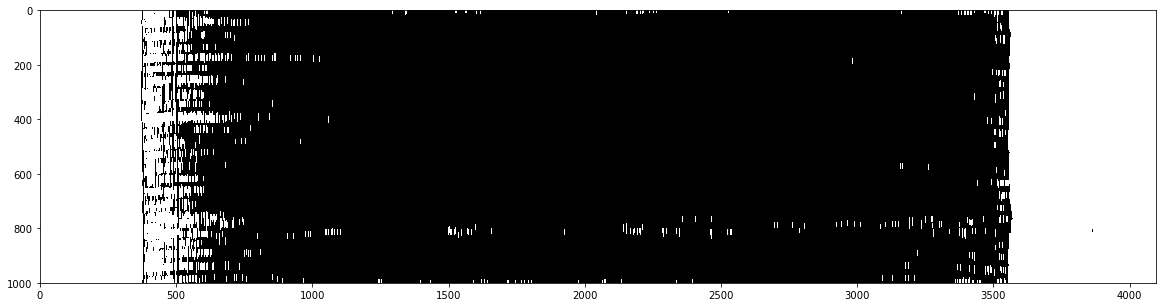

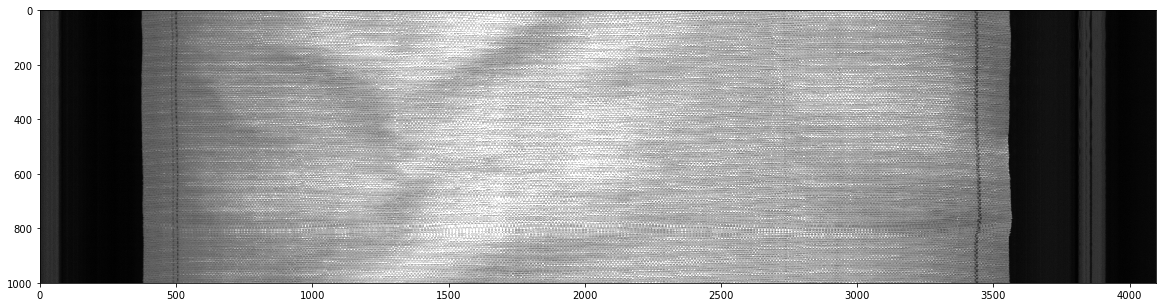

In [13]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
blended = cv2.addWeighted(src1=sobelx,alpha=0.25,src2=sobely,beta=0.75,gamma=0)
kernel = np.ones((20,2),np.uint8)
gradient = cv2.morphologyEx(blended,cv2.MORPH_CLOSE,kernel)
ret, thresh = cv2.threshold(gradient, 30, 255, cv2.THRESH_BINARY_INV)
display_img(gradient)
display_img(thresh)
display_img(img)

#### The next cell takes in images as input and apply the above 2 methods and draws bounding box with true label as well
#### This allows to compare the difference between the true and predicted bounding box

In [ ]:
image_names = os.listdir('test')            # Put the path to test input images
for name in image_names:
    try:

        img = cv2.imread('test/'+name, 0)   # The same path mentioned above goes here also

        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=19)
        sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
        blended = cv2.addWeighted(src1=sobelx,alpha=0.25,src2=sobely,beta=0.75,gamma=0)
        kernel = np.ones((20,2),np.uint8)
        gradient = cv2.morphologyEx(blended,cv2.MORPH_CLOSE,kernel)
        ret, thresh1 = cv2.threshold(gradient, 4, 255, cv2.THRESH_BINARY_INV)


        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
        sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
        blended = cv2.addWeighted(src1=sobelx,alpha=0.25,src2=sobely,beta=0.75,gamma=0)
        kernel = np.ones((20,2),np.uint8)
        gradient = cv2.morphologyEx(blended,cv2.MORPH_CLOSE,kernel)
        ret, thresh2 = cv2.threshold(gradient, 30, 255, cv2.THRESH_BINARY_INV)

        img = cv2.merge((img,img,img))
        for num, thresh in enumerate([thresh1, thresh2]):
            roi = thresh[:, 1000:3000].astype(dtype='uint8')

            temp = np.zeros((1000, 2000, 3), dtype='uint8')
            temp[:, :, 0] = roi
            temp[:, :, 1] = roi
            temp[:, :, 2] = roi

            arr = []
            for i in range(425):
                box = temp[0+2*i:150+2*i, 10:1990, 0]
                heat = box.sum()
                arr.append(heat)


            maxx = arr.index(max(arr[1:-1]))


            cv2.rectangle(img, (700,maxx*2), (3350, 2*maxx+150), (abs(1-num)*255, num*255, 0), 3)
            cv2.putText(img, f'Method{num+1}',(700,maxx*2), cv2.FONT_HERSHEY_COMPLEX, 2, (abs(1-num)*255, num*255, 0), 2)
            #display_img(img)

        a, b = name.split('.')[0], name.split('.')[1] 
        path = f'test/{a}_result.{b}'
        
        # Provide path to true labels to make true bounding boxex
        
        file=open(f"test_labels/{a}.txt","r")          
        cls, x, y, w, h = file.readline().split(' ')
        x, y, w, h = float(x), float(y), float(w), float(h) 
        #print(4096*x, 1000*y)
        #print(4096*(x-w/2), 1000*(y-h/2))
        #print(4096*(x+w/2), 1000*(y+h/2))
        cv2.rectangle(img, (int(4096*(x-w/2)),int(1000*(y-h/2))), (int(4096*(x+w/2)), int(1000*(y+h/2))), (0, 0, 255), 3)
        cv2.putText(img, f'Truth',(int(4096*(x-w/2)),int(1000*(y-h/2))), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 255), 2)
        cv2.imwrite(path, img)
        file.close()
    except:
        print(name)

# Approach 2 - Feature Matching

#### This approach matches the feature of defect in an image

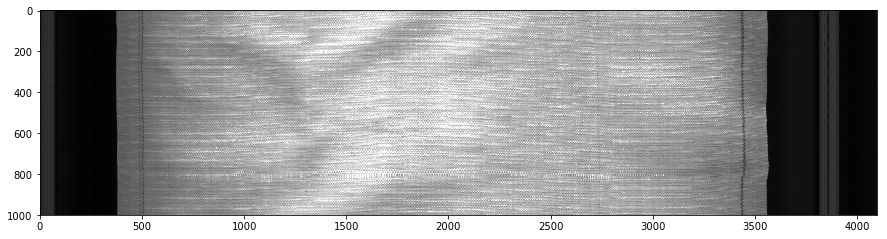

In [46]:
# Input the path to test image
img = cv2.imread('test/img_1478.jpg', 0)
plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')

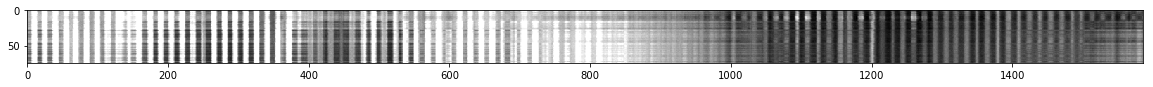

In [4]:
# Input the path to feature image
feat = cv2.imread('feature.PNG', 0)
display_img(feat)

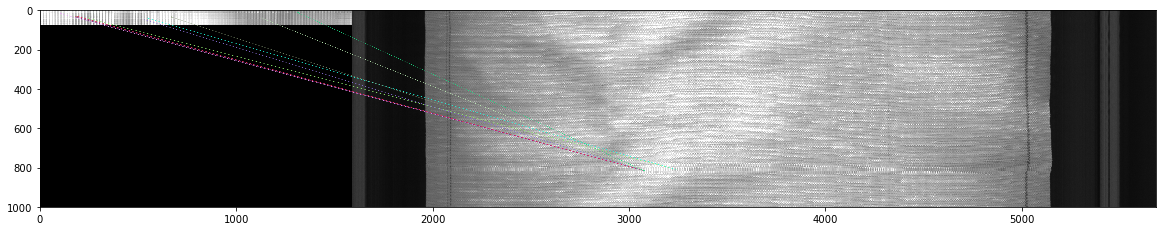

In [20]:
sift = cv2.xfeatures2d.SIFT_create()
kp1,des1 = sift.detectAndCompute(feat,None)
kp2,des2 = sift.detectAndCompute(img,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
good = []
#less distance == better match
#ratio match1 < 75% match 2
for match1,match2 in matches:
    #if so then keep it, its a good match
    if match1.distance < 0.75*match2.distance:
        good.append([match1])
        
sift_matches = cv2.drawMatchesKnn(feat,kp1,img,kp2,good,None,flags=2)
display_img(sift_matches)

#### Trying the same procedure with different test image to prove generalisation 

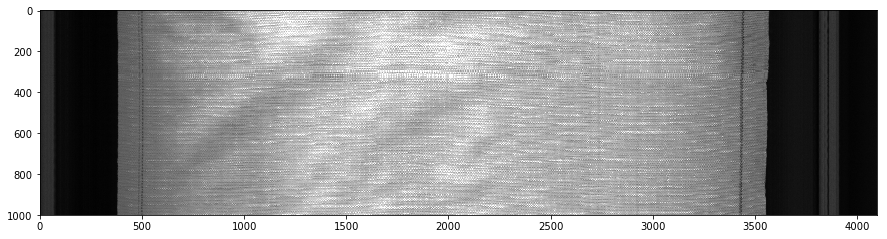

In [11]:
img = cv2.imread('test/img_1570.jpg', 0)
plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')

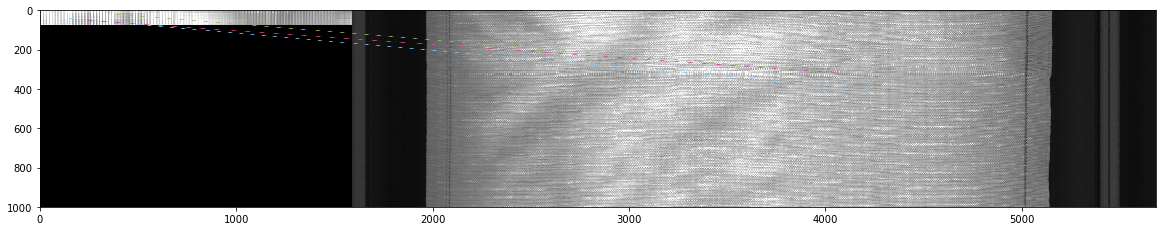

In [12]:
sift = cv2.xfeatures2d.SIFT_create()
kp1,des1 = sift.detectAndCompute(feat,None)
kp2,des2 = sift.detectAndCompute(img,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
good = []
#less distance == better match
#ratio match1 < 75% match 2
for match1,match2 in matches:
    #if so then keep it, its a good match
    if match1.distance < 0.75*match2.distance:
        good.append([match1])
        
sift_matches = cv2.drawMatchesKnn(feat,kp1,img,kp2,good,None,flags=2)
display_img(sift_matches)

#### The left image is the feature of defect and the right image is the target image
#### It can be seen that the defect is detected in both cases

# Approach 3 - Classification using Linear Binary Patterns (lbp)

### This feature exploits the fact the non-defected fabric has a unique uniform pattern and teh defect has its own unique pattern

#### That pattern is computed as local binary pattern and a histogram of patterns is formed. Then these histograms are fed to SVM Classifier for classification
#### The inptut image has to be a small rectangular region of the image
#### A program is used to create the dataset. Code file of which is attached in the folder

In [13]:
# import the necessary packages
from skimage import feature

def describe(image, numPoints,radius, eps=1e-7):
    # compute the Local Binary Pattern representation
    # of the image, and then use the LBP representation
    # to build the histogram of patterns
    lbp = feature.local_binary_pattern(image, numPoints,
        radius, method="uniform")
    
    (hist, _) = np.histogram(lbp.ravel(),
        bins=np.arange(0, numPoints + 3),
        range=(0, numPoints + 2))
    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)

    # return the histogram of Local Binary Patterns
    return hist

#### Extraction of lbp and Training

#### - NOTE The following cell takes time to execute as training of SVM for images(high featured data) is slow process. A pre-trained model has been given to by-pass this step

In [14]:

# import the necessary packages
from sklearn.svm import LinearSVC
from imutils import paths
import argparse
import cv2
import os


# initialize the local binary patterns descriptor along with
# the data and label lists
data = []
labels = []

# loop over the training images
for imagePath in paths.list_images('lbp dataset/train/'):
    # load the image, convert it to grayscale, and describe it
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = describe(gray, 24, 8)

    # extract the label from the image path, then update the
    # label and data lists
    labels.append(imagePath.split(os.path.sep)[-2])
    data.append(hist)
    #print('.', end=' ')
# train a Linear SVM on the data
model = LinearSVC(C=100.0, random_state=42)
model.fit(data, labels)



D:\Anaconda\software\envs\python-cvcourse\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=100.0, random_state=42)

#### Testing

In [44]:
# loop over the testing images
for imagePath in paths.list_images('lbp dataset/test/def'):   # you can put the path as 'lbp dataset/test/no_def' as well to see the predictions on other class 
    # load the image, convert it to grayscale, describe it,
    # and classify it
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = describe(gray, 24, 8)
    prediction = model.predict(hist.reshape(1, -1))
    print("Pridicted label: ", prediction)
    # display the image and the prediction
    cv2.putText(image, prediction[0], (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
        1.0, (0, 0, 255), 1)
    cv2.imshow("Image", image)
    cv2.waitKey(0)
cv2.destroyAllWindows()

# lbp dataset/train/def      - defect
# lbp dataset/train/no_def   - no defect

Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']
Pridicted label:  ['lbp dataset/train/def']


#### we see that model has correctly identified all patterns

#### save the model in either pickle or joblib format

In [25]:
import pickle
pickle.dump(model, open('pickle_model.sav', 'wb'))
import joblib
joblib.dump(model, 'joblib_model.sav')

#### Un-comment this cell and run to load pre-trained model
#model = joblib.load('joblib_model.sav')

#### Testing on real full-size image

#### the image is devided in several rectangular regions and each of that region is fed to SVM classifier, Where the prediction intensity is high, that ROI is classified as the defect

In [23]:
def display_img(img):
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

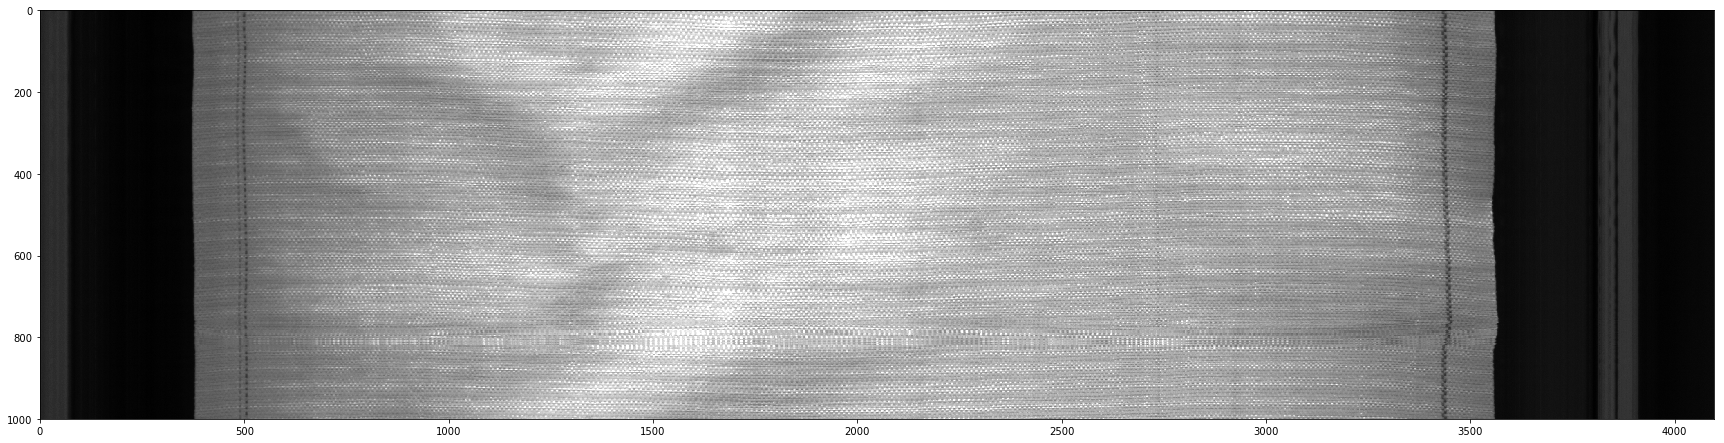

In [25]:
img = cv2.imread('test/img_1478.jpg', 0)
display_img(img)

In [26]:
temp = []
for i in range(150):
    gray = img[6*i:100+6*i, 698:3398]
    hist = describe(gray, 24, 8)
    prediction = model.predict(hist.reshape(1, -1))
    if prediction == 'lbp dataset/train/def':
        temp.append(i)
    

In [37]:
temp_img = img.copy()
for i in temp:
    cv2.rectangle(temp_img, (698, 6*i), (3398,100+6*i), (255), 2)
i = int(np.array(temp).mean())
cv2.rectangle(img, (698, 6*i), (3398,100+6*i), (255), 2)

array([[52, 51, 49, ..., 19, 19, 20],
       [54, 51, 49, ..., 20, 20, 19],
       [51, 51, 51, ..., 19, 20, 19],
       ...,
       [51, 49, 48, ..., 19, 18, 20],
       [51, 50, 47, ..., 19, 19, 19],
       [50, 50, 47, ..., 20, 19, 19]], dtype=uint8)

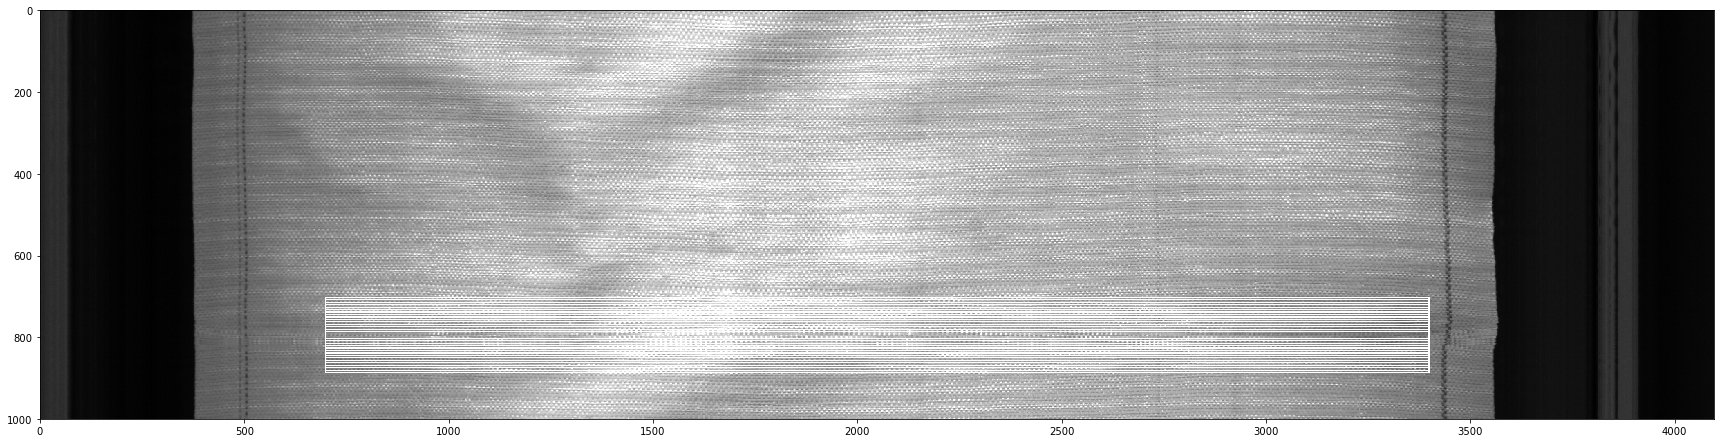

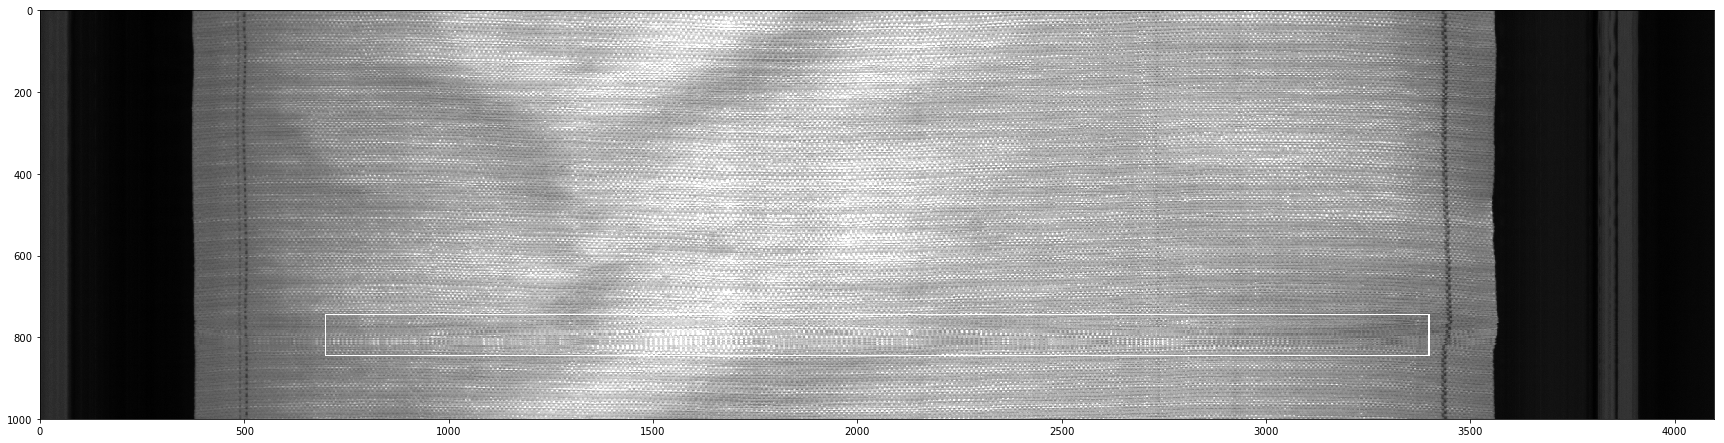

In [39]:
display_img(temp_img)
display_img(img)